# 初始化

> 提供了两种线性回归的实现，1、全部自己写，2、使用`pytorch`提供的工具

In [1]:
!pip install matplotlib_inline

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple


# 自己做

In [2]:
%matplotlib inline 
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline as bcil
import random
import torch
from torch.utils import data
from torch import nn

数据集生成

In [3]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b # matmul() 对比 mm() 可以实现广播
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1)) # reshape中-1表示自动计算

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [5]:
features[0], labels[0]

(tensor([-0.6287,  0.8349]), tensor([0.0954]))

' numpy() 不放到梯度中 '

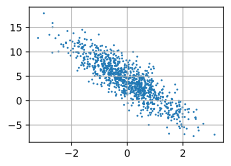

In [6]:
bcil.set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = (3.5, 2.5)
plt.grid()
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), s=1)
""" numpy() 不放到梯度中 """

In [7]:
# 实现小批量读取
def data_iter(batch_size, features, labels):
    num_examples = features.shape[0]
    indices = list(range(num_examples))
    random.shuffle(indices) # 将原列表顺序打乱
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]) # 有可能超出索引范围： min()
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.0178e+00,  1.3123e-01],
        [-3.9517e-01,  2.8532e-01],
        [ 2.2087e+00, -1.8835e-01],
        [-1.9558e+00,  8.1367e-01],
        [ 5.6934e-01,  9.3834e-01],
        [-3.1837e-02,  1.4104e+00],
        [-4.7827e-01, -2.2920e+00],
        [ 1.2004e-03, -3.0201e-01],
        [ 7.6460e-01,  2.3202e-01],
        [-5.5672e-01, -5.7576e-01]]) 
 tensor([[ 1.7227],
        [ 2.4430],
        [ 9.2783],
        [-2.4763],
        [ 2.1323],
        [-0.6596],
        [11.0494],
        [ 5.2101],
        [ 4.9467],
        [ 5.0523]])


参数初始化

In [8]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [9]:
# 定义模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [10]:
# 损失函数
def squred_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2

In [11]:
# 定义优化算法
def sgd(params, lr, batch_size):
    with torch.no_grad(): # 梯度优化不需要梯度计算
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() # 手动归零

In [12]:
lr = 0.1
num_epochs = 10
net = linreg
loss = squred_loss
batch_size = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        # l 的形状是 (batch_size, 1), 不是标量, 无法计算梯度
        # 使用 sum 累加损失
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train = loss(net(features, w, b), labels)
        print(f"epochs {epoch+1}, loss {float(train.mean()):.8f}")

epochs 1, loss 0.00010070
epochs 2, loss 0.00010044
epochs 3, loss 0.00010121
epochs 4, loss 0.00010344
epochs 5, loss 0.00010351
epochs 6, loss 0.00010545
epochs 7, loss 0.00010330
epochs 8, loss 0.00010221
epochs 9, loss 0.00010016
epochs 10, loss 0.00010363


# 利用 `Pytorch` 的工具

In [13]:
""" 使用 Pytorch 提供的工具 """
features, labels = synthetic_data(true_w, true_b, 1000) # 生产初始化参数

In [14]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays) # 当传递值为迭代器时, 使用*修饰
    return data.DataLoader(dataset, batch_size, shuffle = is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size, True)

next(iter(data_iter)) # 得到一个返回

[tensor([[ 0.9045,  0.8903],
         [ 0.0974, -1.2499],
         [ 0.5129, -0.7398],
         [-1.2968,  0.6867],
         [ 1.0031, -0.3060],
         [ 1.4880,  0.5389],
         [ 1.8875,  0.1248],
         [ 0.0504,  0.2228],
         [ 0.9706, -1.5496],
         [-1.1531, -1.4712]]),
 tensor([[ 2.9921],
         [ 8.6421],
         [ 7.7460],
         [-0.7173],
         [ 7.2311],
         [ 5.3462],
         [ 7.5429],
         [ 3.5480],
         [11.4098],
         [ 6.8936]])]

In [15]:
""" Sequential : list of layers"""
net = nn.Sequential(nn.Linear(2, 1)) # 等价于全连接层

In [16]:
""" 初始化参数模型 """
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [17]:
loss = nn.MSELoss() # 均方误差

In [18]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [19]:
num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y) # Pytorch 默认进行了 sum() 运算
        trainer.zero_grad()
        l.backward()
        trainer.step()
    with torch.no_grad():
        l = loss(net(features), labels)
        print(f"epochs: {epoch + 1}, loss:{l:.8f}") # MSELoss没有 / 2

epochs: 1, loss:0.00023832
epochs: 2, loss:0.00010006
epochs: 3, loss:0.00010025
epochs: 4, loss:0.00009992
epochs: 5, loss:0.00009990
epochs: 6, loss:0.00010016
epochs: 7, loss:0.00010040
epochs: 8, loss:0.00010000
epochs: 9, loss:0.00009984
epochs: 10, loss:0.00010038


`batchsize` 反直觉

  有的时候越小越好？ 

> 小的`batchsize`可以提高噪声，提高鲁棒性？

建模是不精确的，优化也是不精确的[即深度学习的两个模型都是不精确的]

- 不太关心统计的最优解
- 关心**收敛的地方**，希望收敛的地方平坦，范化性很好

batch_size 不是整数倍
1. 调整 batch_size
2. 舍弃数据多余部分
3. 从下一个 epoch 中借用数据

NaN 是由于每一次梯度迭代存在除法

> 有可能被除数有 0 或者 inf
